In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","337,944.45","5,304.00",1.59%
1,4,r,"81,991.16","73,705.96","-8,285.21",-10.11%
2,2,f,"11,349.85","11,635.98",286.13,2.52%
3,1,c,"6,354.00","7,811.75","1,457.75",22.94%
4,3,p,"3,235.36","3,189.01",-46.35,-1.43%
5,Total,Total,"435,570.83","434,287.15","-1,283.68",-0.29%


In [3]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

,submode,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Link Red Line,"78,765.00","91,203.00","70,462.97",-10.54%,-22.74%
1,Sounder,"6,765.00","7,711.00","7,811.75",15.47%,1.31%


### boarding by agency

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [5]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

C:\Users\Modeller\AppData\Local\Temp\ipykernel_22904\1611307006.py:4: FutureWarning:

The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","239,389.42","-13,924.20",-5.50%
1,5,Sound Transit,"113,374.00","128,635.16","15,261.16",13.46%
2,0,Community Transit,"25,962.00","26,108.00",146.00,0.56%
3,4,Pierce Transit,"21,185.00","14,293.40","-6,891.60",-32.53%
4,6,Washington Ferries,"9,278.21","6,705.88","-2,572.33",-27.72%
5,3,Kitsap Transit,"8,258.00","15,216.34","6,958.34",84.26%
6,1,Everett Transit,"4,201.00","3,922.71",-278.29,-6.62%
7,Total,Total,"435,571.83","434,270.90","-1,300.92",-0.30%


In [6]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

,agency,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Community Transit,"23,000.00",0.00,"26,108.00",13.51%,-
1,Everett Transit,0.00,0.00,"3,922.71",-,-
2,King County Metro,"244,306.00","272,556.00","239,389.42",-2.01%,-12.17%
3,Kitsap Transit,"8,000.00","9,300.00","15,216.34",90.20%,63.62%
4,Pierce Transit,"19,974.00",0.00,"14,293.40",-28.44%,-
5,Sound Transit,"115,516.00","133,703.00","128,635.16",11.36%,-3.79%
6,Washington Ferries,0.00,0.00,"6,705.88",-,-


### boarding by key route

In [7]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff


In [8]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [9]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4202,Brem-Annapolis FF,674.20
2,4200,Seattle-Bremerton FF,574.30
3,4201,Brem-Pt Orchard FF,501.10
0,1973,973 W Sea Water Taxi,497.20
1,1975,975 Vashn Water Taxi,260.20
5,4203,Seattle-Kingston FF,251.20
11,5005,WSF Fauntleroy-Vashn,228.50
12,5007,WSF Pt Def-Tahlequah,183.00
8,5002,WSF Seattle-Bain Isl,121.10
10,5004,WSF Fauntleroy-Swrth,56.50


In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Sounder South,"6,038.00","7,805.34","1,767.34",29.27%
1,Sounder North,316.00,6.41,-309.59,-97.97%


r^2 : 1.0


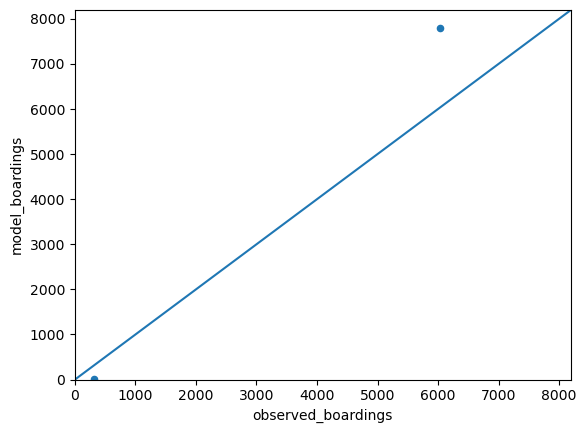

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [12]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
4,E Line RapidRide,"11,426.00","12,935.66","1,509.66",13.21%
2,C Line RapidRide,"7,250.00","9,718.24","2,468.24",34.04%
3,D Line RapidRide,"9,044.00","6,698.13","-2,345.87",-25.94%
0,A Line RapidRide,"8,412.00","6,001.06","-2,410.94",-28.66%
1,B Line RapidRide,"4,177.00","3,177.74",-999.26,-23.92%


r^2 : 0.8062388303705185


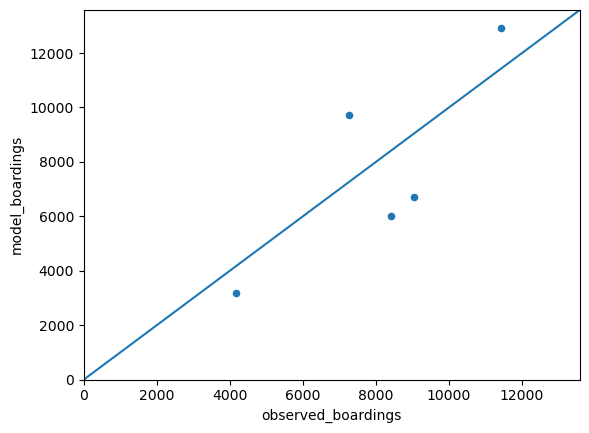

In [13]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.942407680505321
r^2 Everett Transit: 0.9866932728039919
r^2 King County Metro: 0.927059174571671
r^2 Kitsap Transit: 0.932442916026889
r^2 Pierce Transit: 0.6942427688391551
r^2 Sound Transit: 0.9938951760659525
r^2 Washington Ferries: 0.9447626712070937


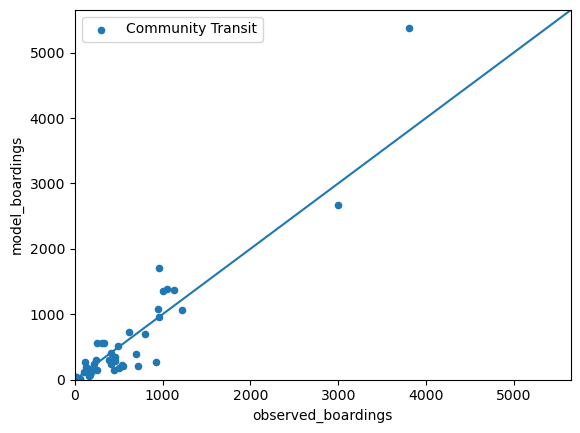

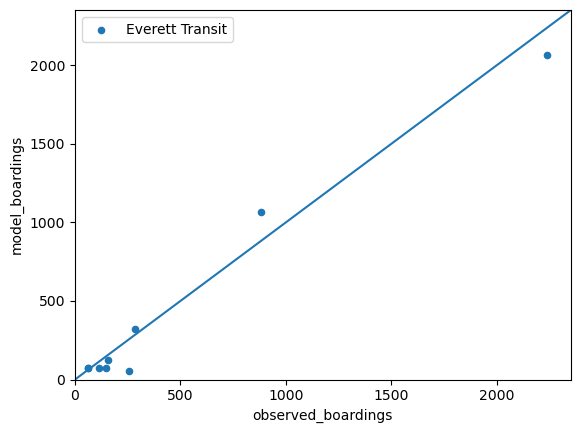

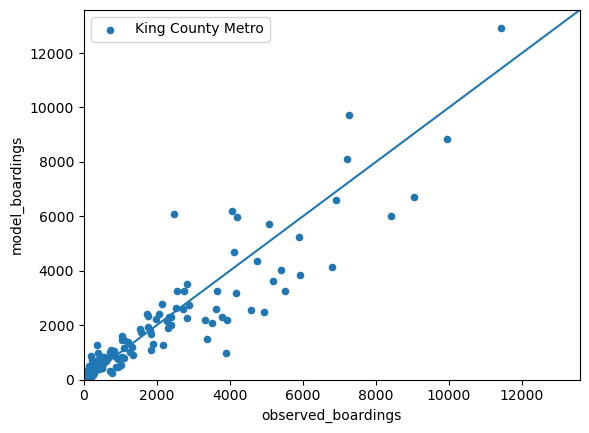

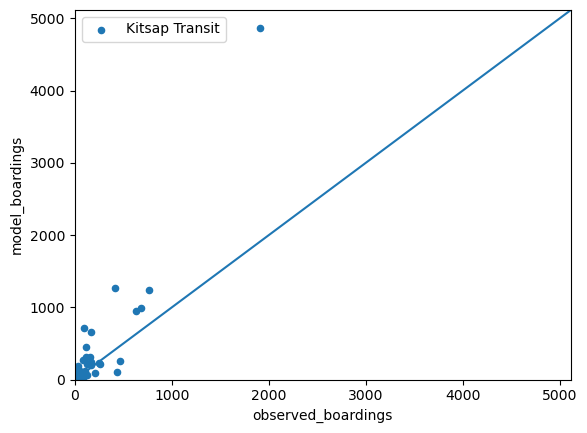

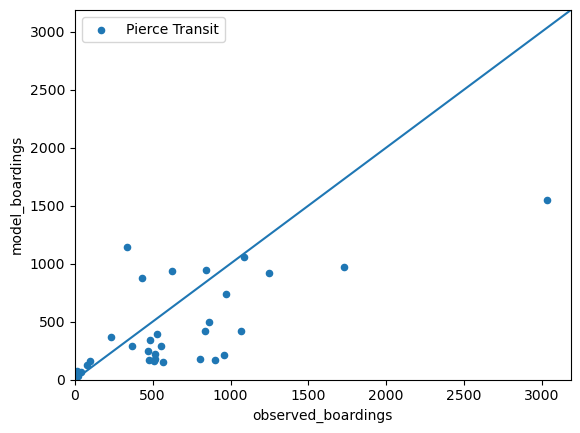

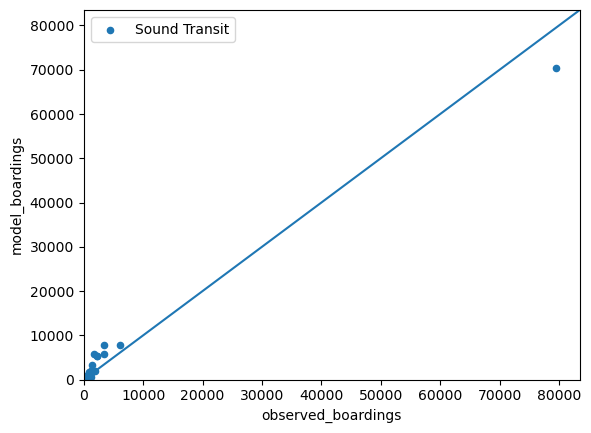

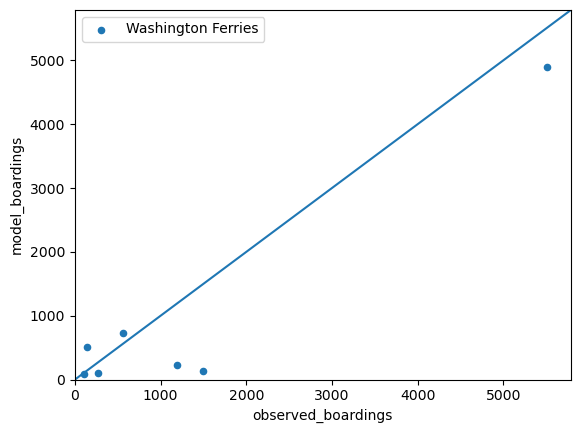

In [14]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","3,554.17","-2,579.83",-42.06%
Westlake,"8,845.00","9,485.47",640.47,7.24%
University St,"4,324.00","5,670.90","1,346.90",31.15%
Pioneer Square,"2,400.00","4,971.69","2,571.69",107.15%
Int'l District,"4,399.00","1,773.78","-2,625.22",-59.68%
Capitol Hill,"7,667.00","6,472.34","-1,194.66",-15.58%
Stadium,"1,731.00",269.73,"-1,461.27",-84.42%
SODO,"1,669.00","1,876.93",207.93,12.46%
Beacon Hill,"2,147.00","1,068.29","-1,078.71",-50.24%


In [16]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","3,554.17","-2,579.83",-42.06%
Capitol Hill,"7,667.00","6,472.34","-1,194.66",-15.58%
Westlake/University St,"13,169.00","15,156.37","1,987.37",15.09%
Pioneer Square/Int'l District,"6,799.00","6,745.47",-53.53,-0.79%
Stadium/SODO,"3,400.00","2,146.67","-1,253.33",-36.86%
Beacon Hill/Mount Baker,"4,008.00","2,341.33","-1,666.67",-41.58%
Columbia City,"1,630.00","1,355.49",-274.51,-16.84%
Othello/Rainier Beach,"3,525.00","2,673.49",-851.51,-24.16%
Tukwila Int'l Blvd,"2,298.00","1,800.60",-497.40,-21.64%


## light rail stop transfers

In [17]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.84,-99.00,99.84,-100.85%
Westlake,0.12,0.36,-0.24,-66.25%
University St,0.27,0.20,0.07,36.89%
Pioneer Square,0.41,0.16,0.25,157.07%
Int'l District,0.55,0.45,0.10,23.29%
Capitol Hill,0.05,-99.00,99.05,-100.05%
Stadium,0.32,0.12,0.20,167.62%
SODO,0.62,0.31,0.31,98.63%
Beacon Hill,0.35,0.35,-0.01,-1.72%
